<a href="https://colab.research.google.com/github/pierce3215/finances/blob/main/LSTM_Technical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
import math
import pandas_datareader as web
import yfinance as yf

https://github.com/tejaslinge/Stock-Price-Prediction-using-LSTM-and-Technical-Indicators/blob/main/Price%20Prediction%20using%20LSTM%20and%20TA.ipynb

In [9]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [10]:
ticker = input("ENTER THE STOCK WHOSE PREDICTION YOU WANT : ")
data = yf.download(ticker, start='2000-01-01' , end='2023-10-06')
print(data.tail())

ENTER THE STOCK WHOSE PREDICTION YOU WANT : SPY
[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-09-29  431.670013  431.850006  425.910004  427.480011  427.480011   
2023-10-02  426.619995  428.600006  424.459991  427.309998  427.309998   
2023-10-03  425.059998  427.369995  420.179993  421.589996  421.589996   
2023-10-04  422.070007  425.429993  420.559998  424.660004  424.660004   
2023-10-05  424.359985  425.369995  421.170013  424.500000  424.500000   

               Volume  
Date                   
2023-09-29  115078500  
2023-10-02   83798600  
2023-10-03  103760600  
2023-10-04   87453000  
2023-10-05   70142700  


In [11]:
data = data[['Adj Close']]
data.columns = ['Price']
data.head()

,Price
Date,
2000-01-03,94.262535
2000-01-04,90.576317
2000-01-05,90.738380
2000-01-06,89.280067
2000-01-07,94.465103


In [12]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 5978 number of days in the dataset.


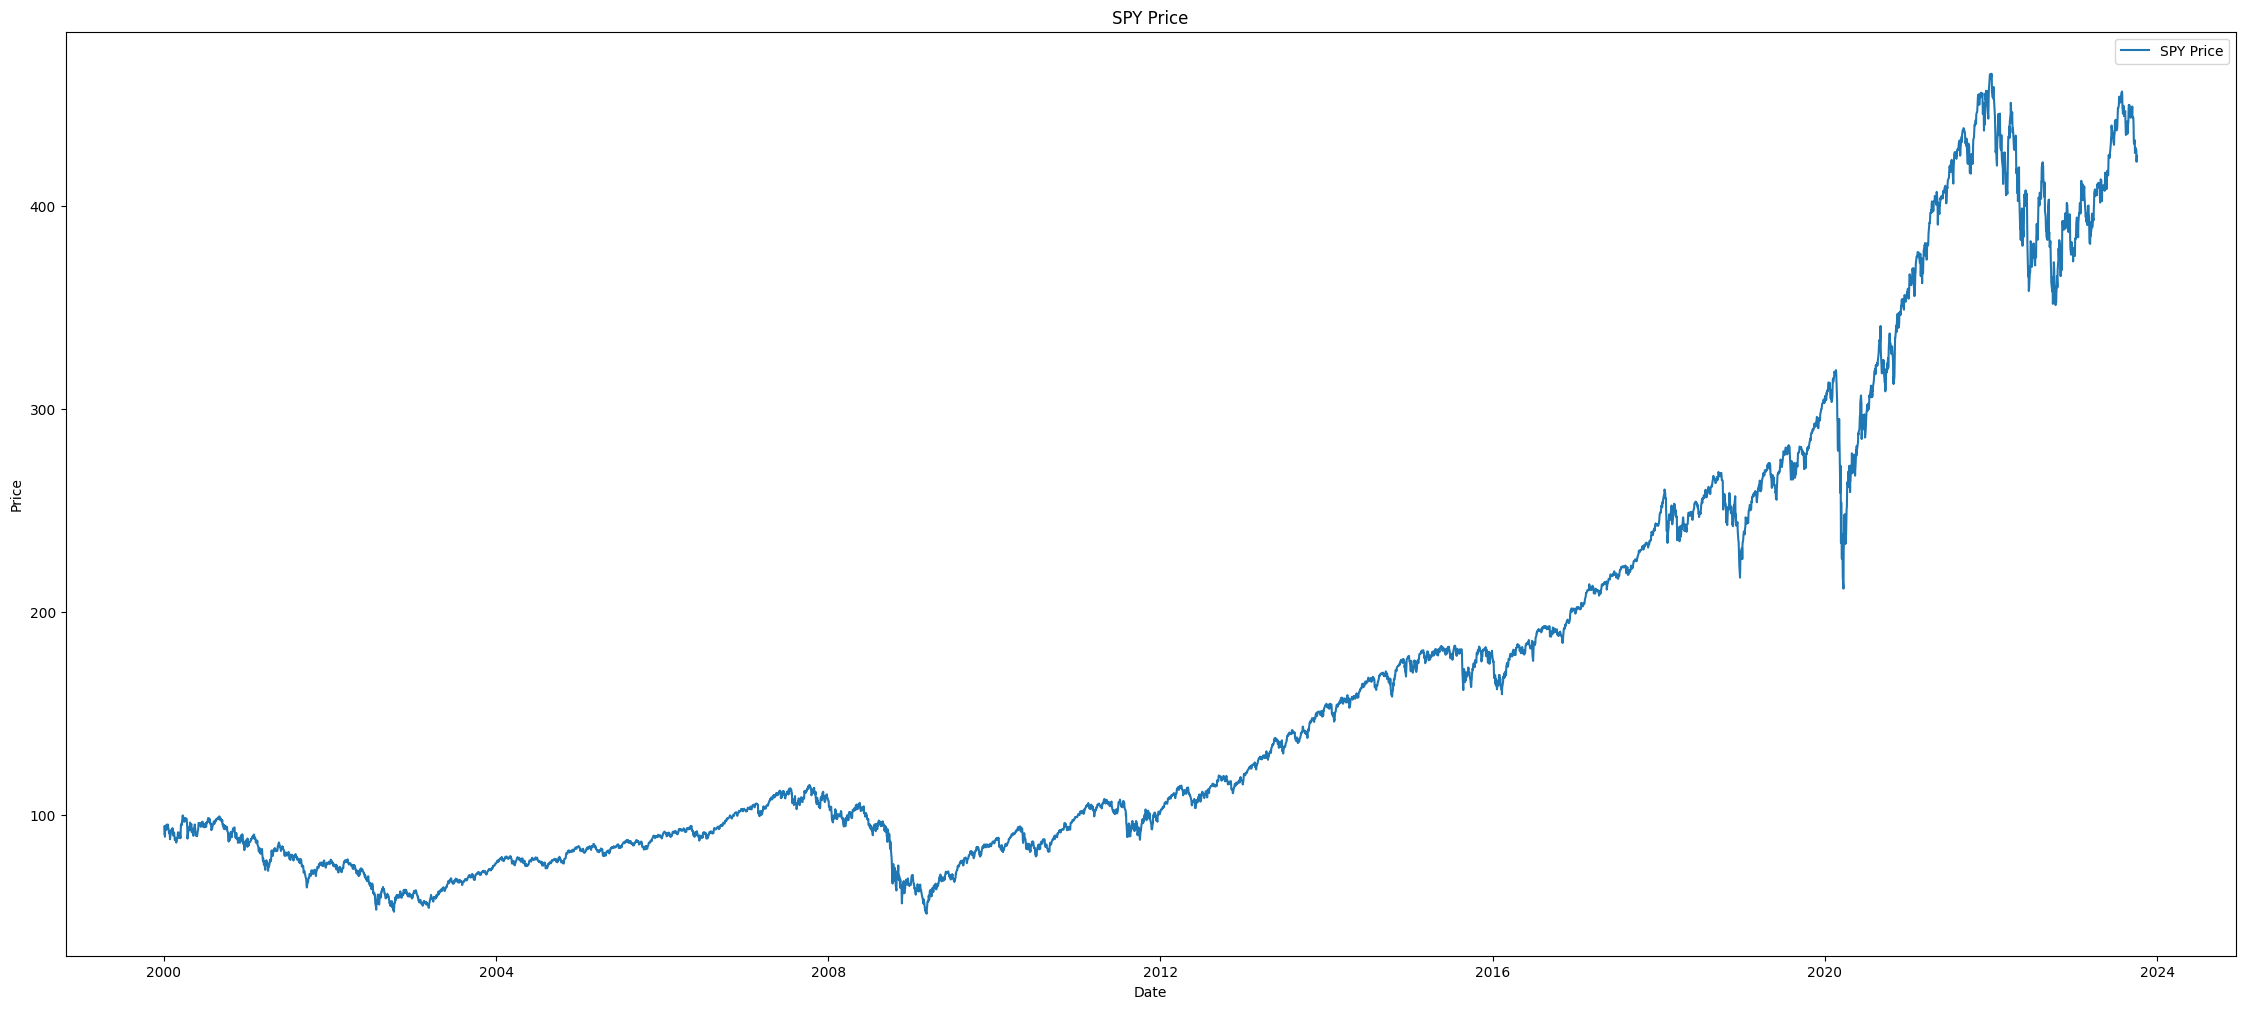

In [13]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(data.index, data['Price'], label='SPY Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SPY Price')
plt.legend()
plt.show()

In [14]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Price'].rolling(window=21).mean()

    # Create MACD
    dataset['26ema'] = dataset['Price'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Price'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Price'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['Price'].ewm(com=0.5).mean()

    # Create Momentum
    dataset['momentum'] = dataset['Price']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset

In [15]:
df = get_technical_indicators(data)

<ipython-input-14-c0fc4fb141be>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
<ipython-input-14-c0fc4fb141be>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['ma21'] = dataset['Price'].rolling(window=21).mean()
<ipython-input-14-c0fc4fb141be>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [16]:
df = df.dropna()
df.head()

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2000-02-01,91.345970,90.712308,92.472488,92.083847,91.555392,-0.528455,2.087111,96.646710,88.298265,90.895770,90.345970,4.503646
2000-02-02,91.426994,90.778853,92.337462,92.024224,91.535125,-0.489099,2.057020,96.451501,88.223423,91.249920,90.426994,4.504543
2000-02-03,92.804268,90.894592,92.443555,92.093866,91.734656,-0.359210,2.018743,96.481041,88.406068,92.286152,91.804268,4.519659
2000-02-04,92.419449,91.059522,92.523606,92.122499,91.841956,-0.280543,1.980718,96.485042,88.562170,92.375017,91.419449,4.515458
2000-02-07,92.277695,91.256281,92.666350,92.135960,91.910038,-0.225922,1.838164,96.342677,88.990022,92.310135,91.277695,4.513906


In [17]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.figure(figsize=(30,20))
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot

    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
#     plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

<Figure size 1600x1000 with 0 Axes>

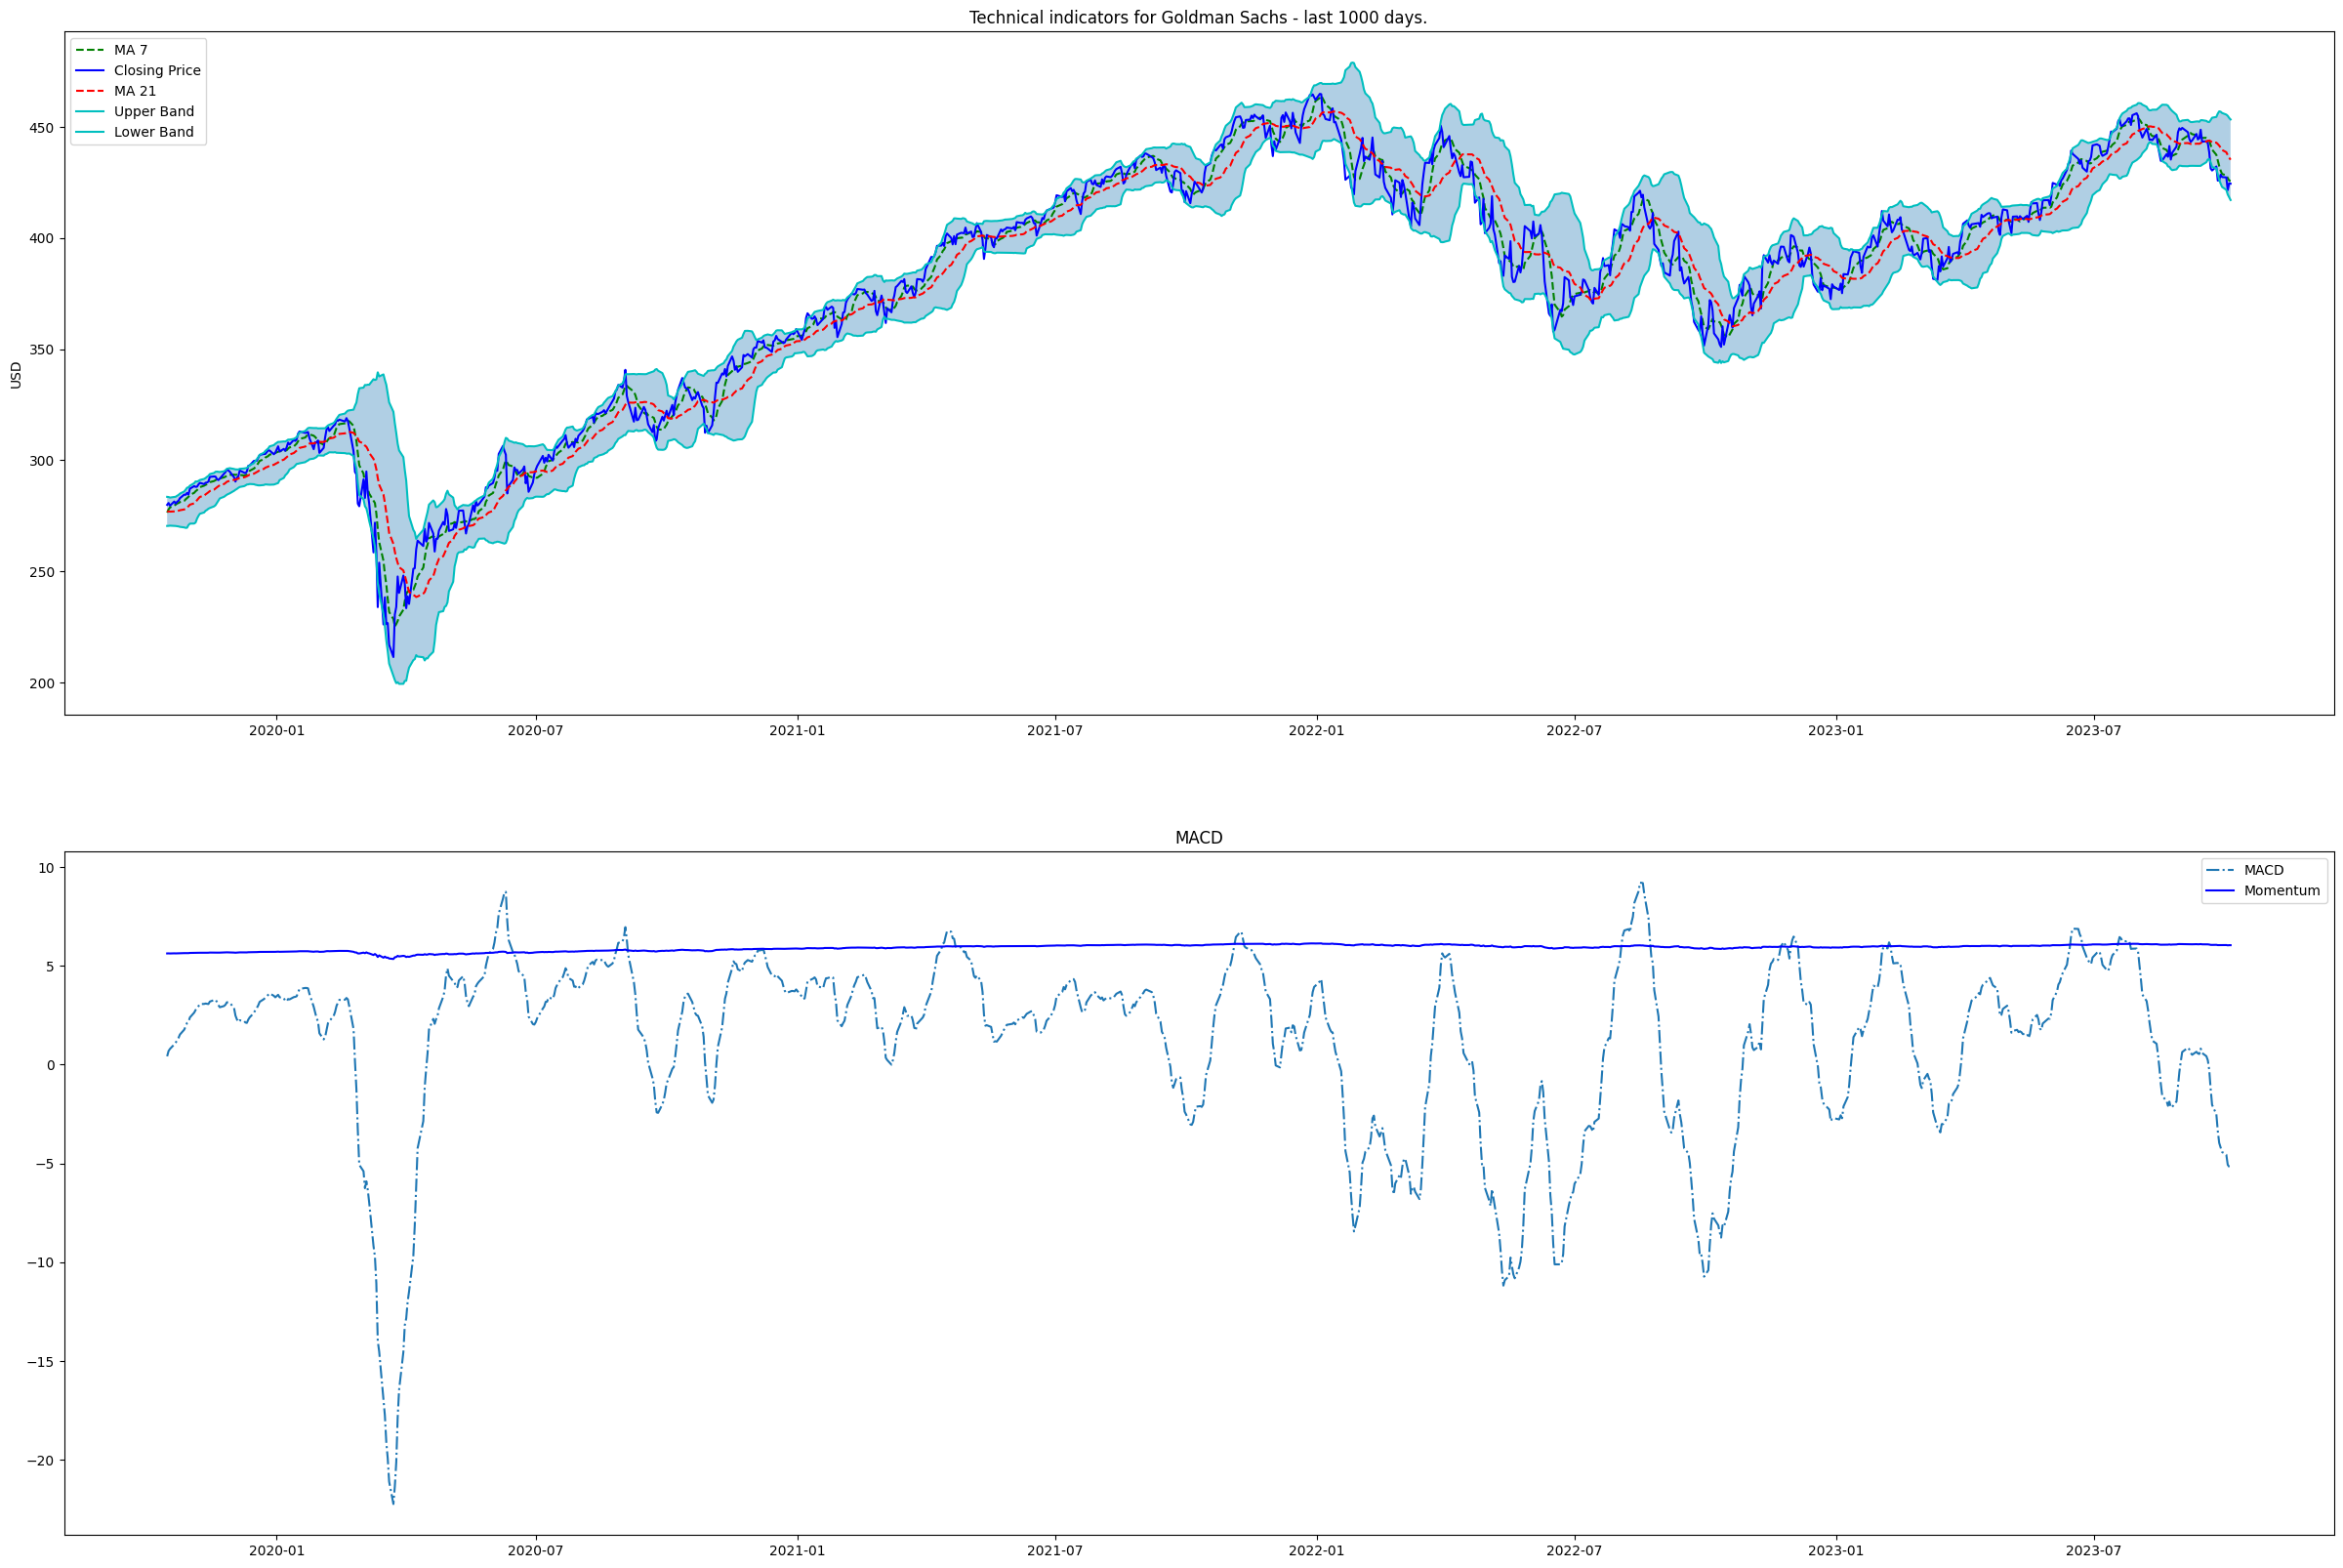

In [18]:
plot_technical_indicators(df, 1000)

Text(0.5, 1.0, 'Params')

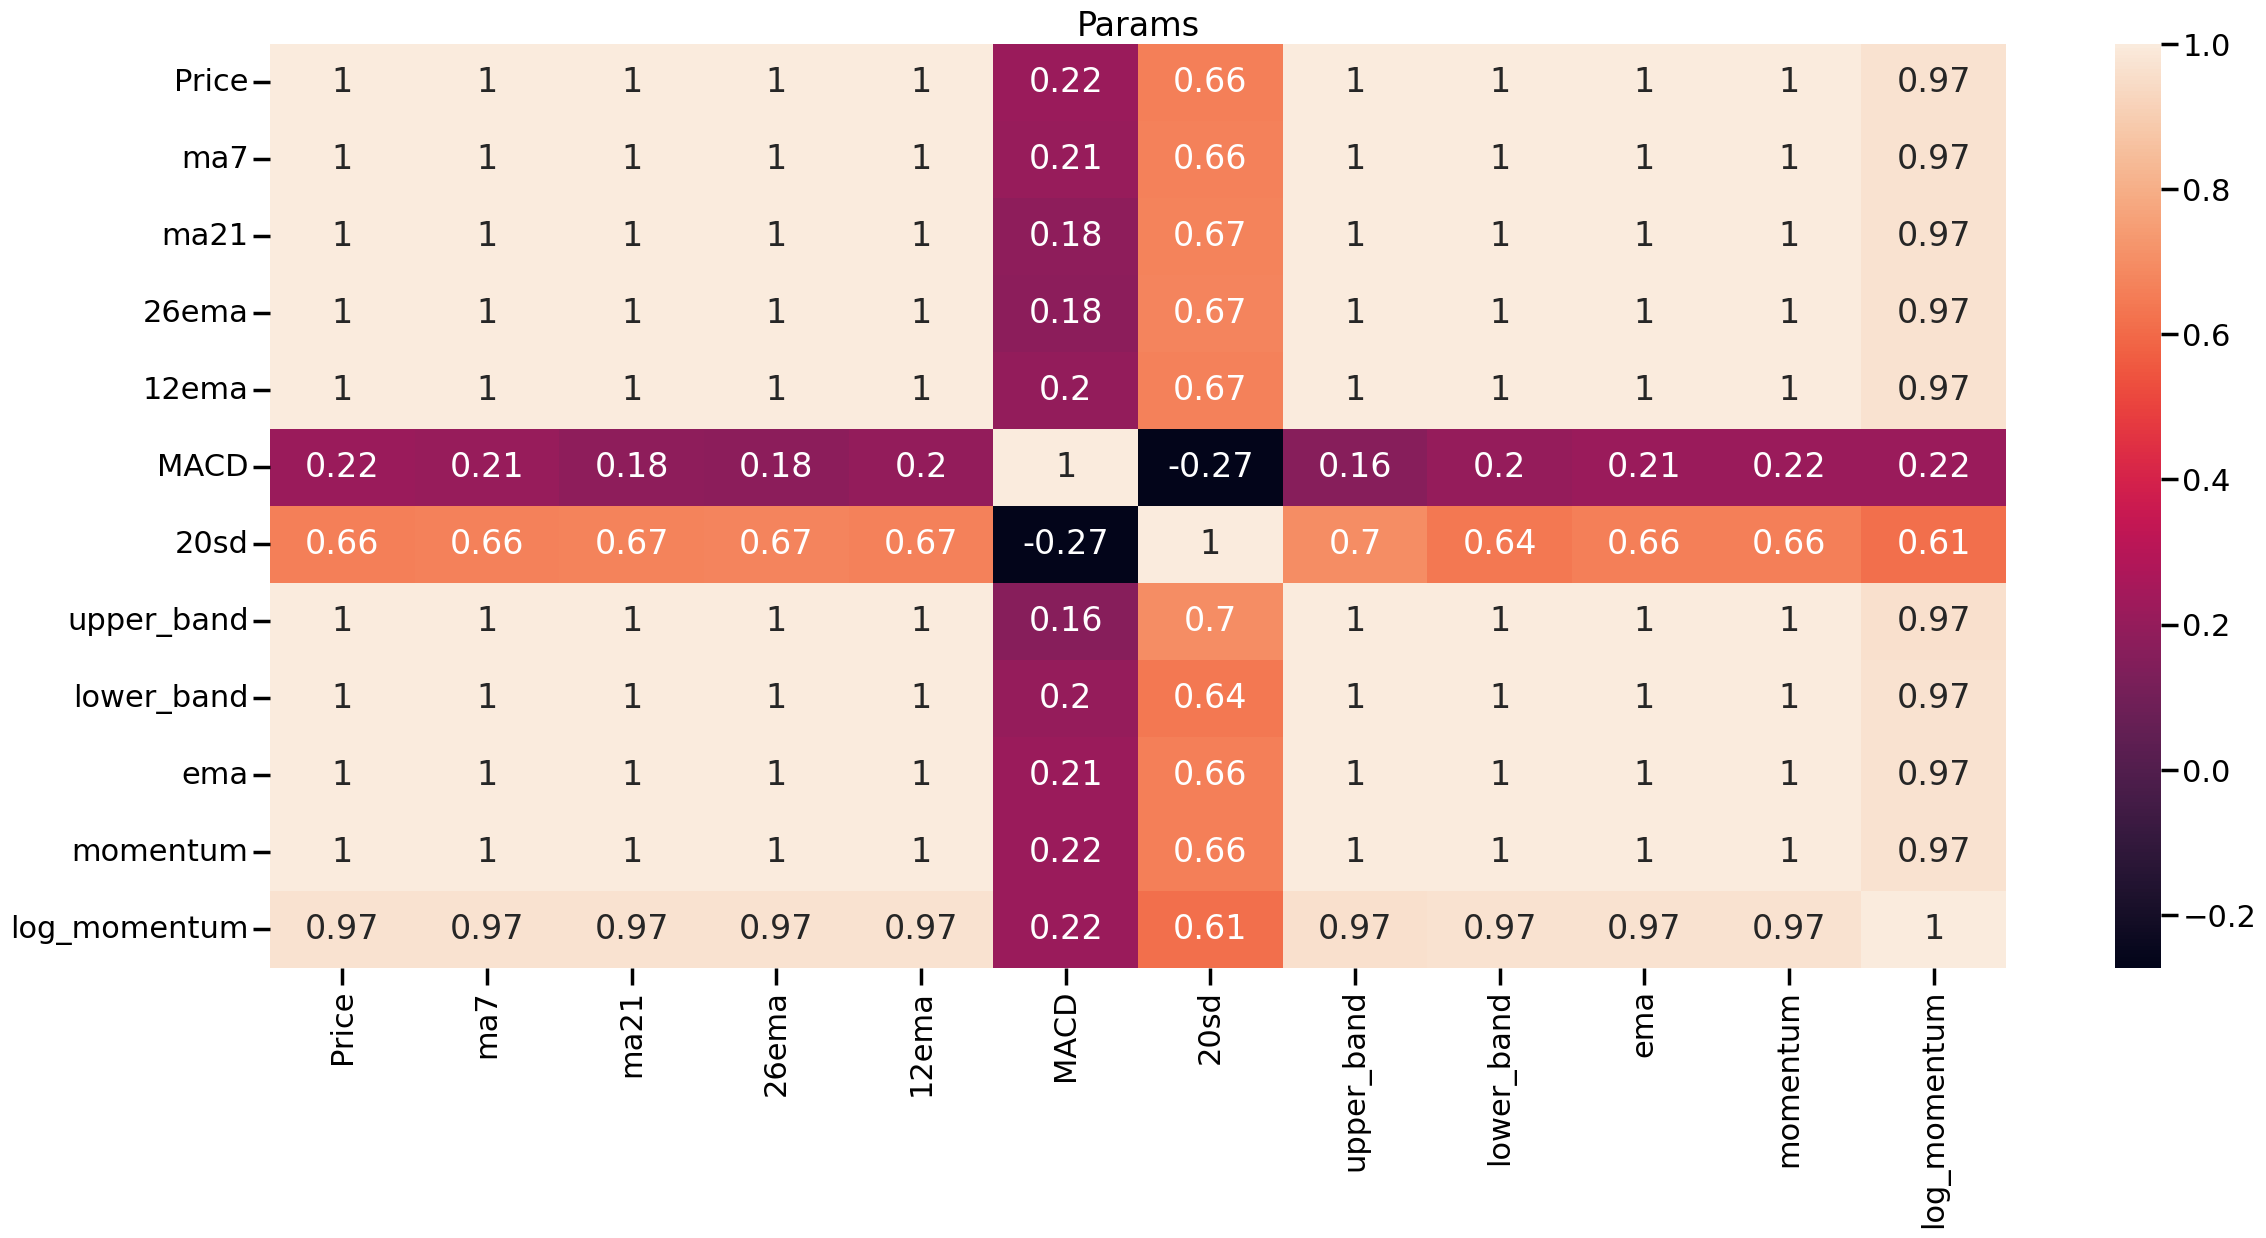

In [19]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(df.corr(), annot = True).set_title('Params')

In [20]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 5958 samples, and 12 features.


In [21]:
df.columns

Index(['Price', 'ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band',
       'lower_band', 'ema', 'momentum', 'log_momentum'],
      dtype='object')

In [22]:
df

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2000-02-01,91.345970,90.712308,92.472488,92.083847,91.555392,-0.528455,2.087111,96.646710,88.298265,90.895770,90.345970,4.503646
2000-02-02,91.426994,90.778853,92.337462,92.024224,91.535125,-0.489099,2.057020,96.451501,88.223423,91.249920,90.426994,4.504543
2000-02-03,92.804268,90.894592,92.443555,92.093866,91.734656,-0.359210,2.018743,96.481041,88.406068,92.286152,91.804268,4.519659
2000-02-04,92.419449,91.059522,92.523606,92.122499,91.841956,-0.280543,1.980718,96.485042,88.562170,92.375017,91.419449,4.515458
2000-02-07,92.277695,91.256281,92.666350,92.135960,91.910038,-0.225922,1.838164,96.342677,88.990022,92.310135,91.277695,4.513906
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29,427.480011,428.852862,439.678941,437.538269,433.118627,-4.419642,8.320077,456.319094,423.038787,427.622208,426.480011,6.055565
2023-10-02,427.309998,428.270002,438.657176,436.780619,432.224992,-4.555627,8.464474,455.586123,421.728228,427.414068,426.309998,6.055167
2023-10-03,421.589996,427.008571,437.323171,435.655388,430.588839,-5.066549,8.851635,455.026441,419.619901,423.531353,420.589996,6.041658


In [23]:
data_training = df[df.index < '2019-01-31'].copy()
data_training

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2000-02-01,91.345970,90.712308,92.472488,92.083847,91.555392,-0.528455,2.087111,96.646710,88.298265,90.895770,90.345970,4.503646
2000-02-02,91.426994,90.778853,92.337462,92.024224,91.535125,-0.489099,2.057020,96.451501,88.223423,91.249920,90.426994,4.504543
2000-02-03,92.804268,90.894592,92.443555,92.093866,91.734656,-0.359210,2.018743,96.481041,88.406068,92.286152,91.804268,4.519659
2000-02-04,92.419449,91.059522,92.523606,92.122499,91.841956,-0.280543,1.980718,96.485042,88.562170,92.375017,91.419449,4.515458
2000-02-07,92.277695,91.256281,92.666350,92.135960,91.910038,-0.225922,1.838164,96.342677,88.990022,92.310135,91.277695,4.513906
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-24,243.863525,243.297764,236.083940,239.552218,241.130053,1.577835,7.433418,250.950776,221.217104,243.837793,242.863525,5.492500
2019-01-25,245.926956,244.015533,237.469250,240.024421,241.868038,1.843617,6.289650,250.048549,224.889950,245.230569,244.926956,5.500960
2019-01-28,244.057861,244.383013,238.243860,240.323195,242.204934,1.881740,6.034632,250.313124,226.174597,244.448764,243.057861,5.493300


In [24]:
data_testing = df[df.index >= '2019-01-31'].copy()
data_testing

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2019-01-31,249.766937,245.525118,240.675204,241.737923,244.238091,2.500168,5.695892,252.066987,229.283420,248.639883,248.766937,5.516516
2019-02-01,249.887238,246.404151,241.551157,242.341576,245.107190,2.765615,5.627099,252.805355,230.296959,249.471453,248.887238,5.517000
2019-02-04,251.645309,247.515834,242.773877,243.030741,246.113055,3.082314,4.800791,252.375458,233.172296,250.920690,250.645309,5.524039
2019-02-05,252.700119,248.483429,243.686400,243.746991,247.126449,3.379458,4.778484,253.243367,234.129433,252.106976,251.700119,5.528238
2019-02-06,252.367035,249.670454,244.495377,244.385513,247.932693,3.547180,4.739554,253.974485,235.016269,252.280349,251.367035,5.526914
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29,427.480011,428.852862,439.678941,437.538269,433.118627,-4.419642,8.320077,456.319094,423.038787,427.622208,426.480011,6.055565
2023-10-02,427.309998,428.270002,438.657176,436.780619,432.224992,-4.555627,8.464474,455.586123,421.728228,427.414068,426.309998,6.055167
2023-10-03,421.589996,427.008571,437.323171,435.655388,430.588839,-5.066549,8.851635,455.026441,419.619901,423.531353,420.589996,6.041658


In [25]:
scalar = MinMaxScaler()

data_training_scaled = scalar.fit_transform(data_training)
print(data_training_scaled.shape)
data_training_scaled

(4779, 12)


array([[0.18374631, 0.17617142, 0.17361074, ..., 0.18103045, 0.18374631,
        0.34950038],
       [0.18411888, 0.17648111, 0.1729701 , ..., 0.18266416, 0.18411888,
        0.35003692],
       [0.19045207, 0.17701972, 0.17347347, ..., 0.18744435, 0.19045207,
        0.35908448],
       ...,
       [0.88596862, 0.89130363, 0.8652337 , ..., 0.88937797, 0.88596862,
        0.94185103],
       [0.88447943, 0.89158045, 0.86844061, ..., 0.88717984, 0.88447943,
        0.94105299],
       [0.90222225, 0.89226946, 0.87258619, ..., 0.89831349, 0.90222225,
        0.95049267]])

In [26]:
X_train = []
y_train = []

In [27]:
for i in range(60, data_training.shape[0]):
    X_train.append(data_training_scaled[i-60: i])
    y_train.append(data_training_scaled[i, 0])

In [28]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((4719, 60, 12), (4719,))

In [29]:
regressor = Sequential()

regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 12)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

In [30]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            12600     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [31]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [32]:
regressor.fit(X_train, y_train, epochs=50, batch_size = 64)

Epoch 1/50
74/74 [==============================] - 26s 274ms/step - loss: 0.0267
Epoch 2/50
74/74 [==============================] - 20s 267ms/step - loss: 0.0053
Epoch 3/50
74/74 [==============================] - 20s 276ms/step - loss: 0.0044
Epoch 4/50
74/74 [==============================] - 20s 266ms/step - loss: 0.0040
Epoch 5/50
74/74 [==============================] - 22s 292ms/step - loss: 0.0037
Epoch 6/50
74/74 [==============================] - 20s 273ms/step - loss: 0.0036
Epoch 7/50
74/74 [==============================] - 19s 252ms/step - loss: 0.0032
Epoch 8/50
74/74 [==============================] - 19s 263ms/step - loss: 0.0032
Epoch 9/50
74/74 [==============================] - 19s 255ms/step - loss: 0.0030
Epoch 10/50
74/74 [==============================] - 20s 270ms/step - loss: 0.0029
Epoch 11/50
74/74 [==============================] - 19s 254ms/step - loss: 0.0027
Epoch 12/50
74/74 [==============================] - 20s 273ms/step - loss: 0.0027
Epoch 13/50
7

In [33]:
past_60 = data_training.tail(60)

dt = past_60.append(data_testing, ignore_index = True)
dt

<ipython-input-33-5aa1e953533c>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = past_60.append(data_testing, ignore_index = True)


,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
0,251.610260,246.607134,253.722150,254.248600,250.070800,-4.177800,7.038929,267.800008,239.644291,250.334005,250.610260,5.523899
1,250.119934,247.470548,252.953350,253.942773,250.078359,-3.864414,6.458242,265.869833,240.036866,250.191291,249.119934,5.517934
2,251.499832,247.905548,252.321222,253.761814,250.297047,-3.464767,5.865831,264.052884,240.589560,251.063652,250.499832,5.523458
3,253.091339,249.192139,251.764881,253.712149,250.726938,-2.985211,5.134045,262.032972,241.496790,252.415443,252.091339,5.529791
4,258.509766,251.445973,251.484958,254.067528,251.924296,-2.143232,4.536901,260.558760,242.411156,256.478325,257.509766,5.551058
...,...,...,...,...,...,...,...,...,...,...,...,...
1234,427.480011,428.852862,439.678941,437.538269,433.118627,-4.419642,8.320077,456.319094,423.038787,427.622208,426.480011,6.055565
1235,427.309998,428.270002,438.657176,436.780619,432.224992,-4.555627,8.464474,455.586123,421.728228,427.414068,426.309998,6.055167
1236,421.589996,427.008571,437.323171,435.655388,430.588839,-5.066549,8.851635,455.026441,419.619901,423.531353,420.589996,6.041658
1237,424.660004,425.927141,436.227888,434.840915,429.676710,-5.164205,8.931188,454.090264,418.365511,424.283787,423.660004,6.048931


In [34]:
inputs = scalar.fit_transform(dt)
print(inputs.shape)
inputs

(1239, 12)


array([[0.15847736, 0.08953401, 0.09385226, ..., 0.14333365, 0.15847736,
        0.2209983 ],
       [0.15259801, 0.09314856, 0.09042538, ..., 0.14276299, 0.15259801,
        0.21345326],
       [0.15804172, 0.09496962, 0.08760771, ..., 0.14625121, 0.15804172,
        0.22044078],
       ...,
       [0.82904935, 0.84475625, 0.91224285, ..., 0.83588029, 0.82904935,
        0.87595472],
       [0.84116056, 0.84022902, 0.9073607 , ..., 0.83888897, 0.84116056,
        0.88515465],
       [0.84052935, 0.83940371, 0.90308335, ..., 0.83946533, 0.84052935,
        0.88467681]])

In [35]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((1179, 60, 12), (1179,))

In [36]:
y_pred = regressor.predict(X_test)

37/37 [==============================] - 2s 45ms/step


In [37]:
y_pred

array([[0.09245186],
       [0.09533438],
       [0.09804003],
       ...,
       [0.7237916 ],
       [0.71951294],
       [0.7155163 ]], dtype=float32)

In [38]:
scale = 1/scalar.scale_[0]

In [39]:
y_pred = y_pred*scale
y_test = y_test*scale

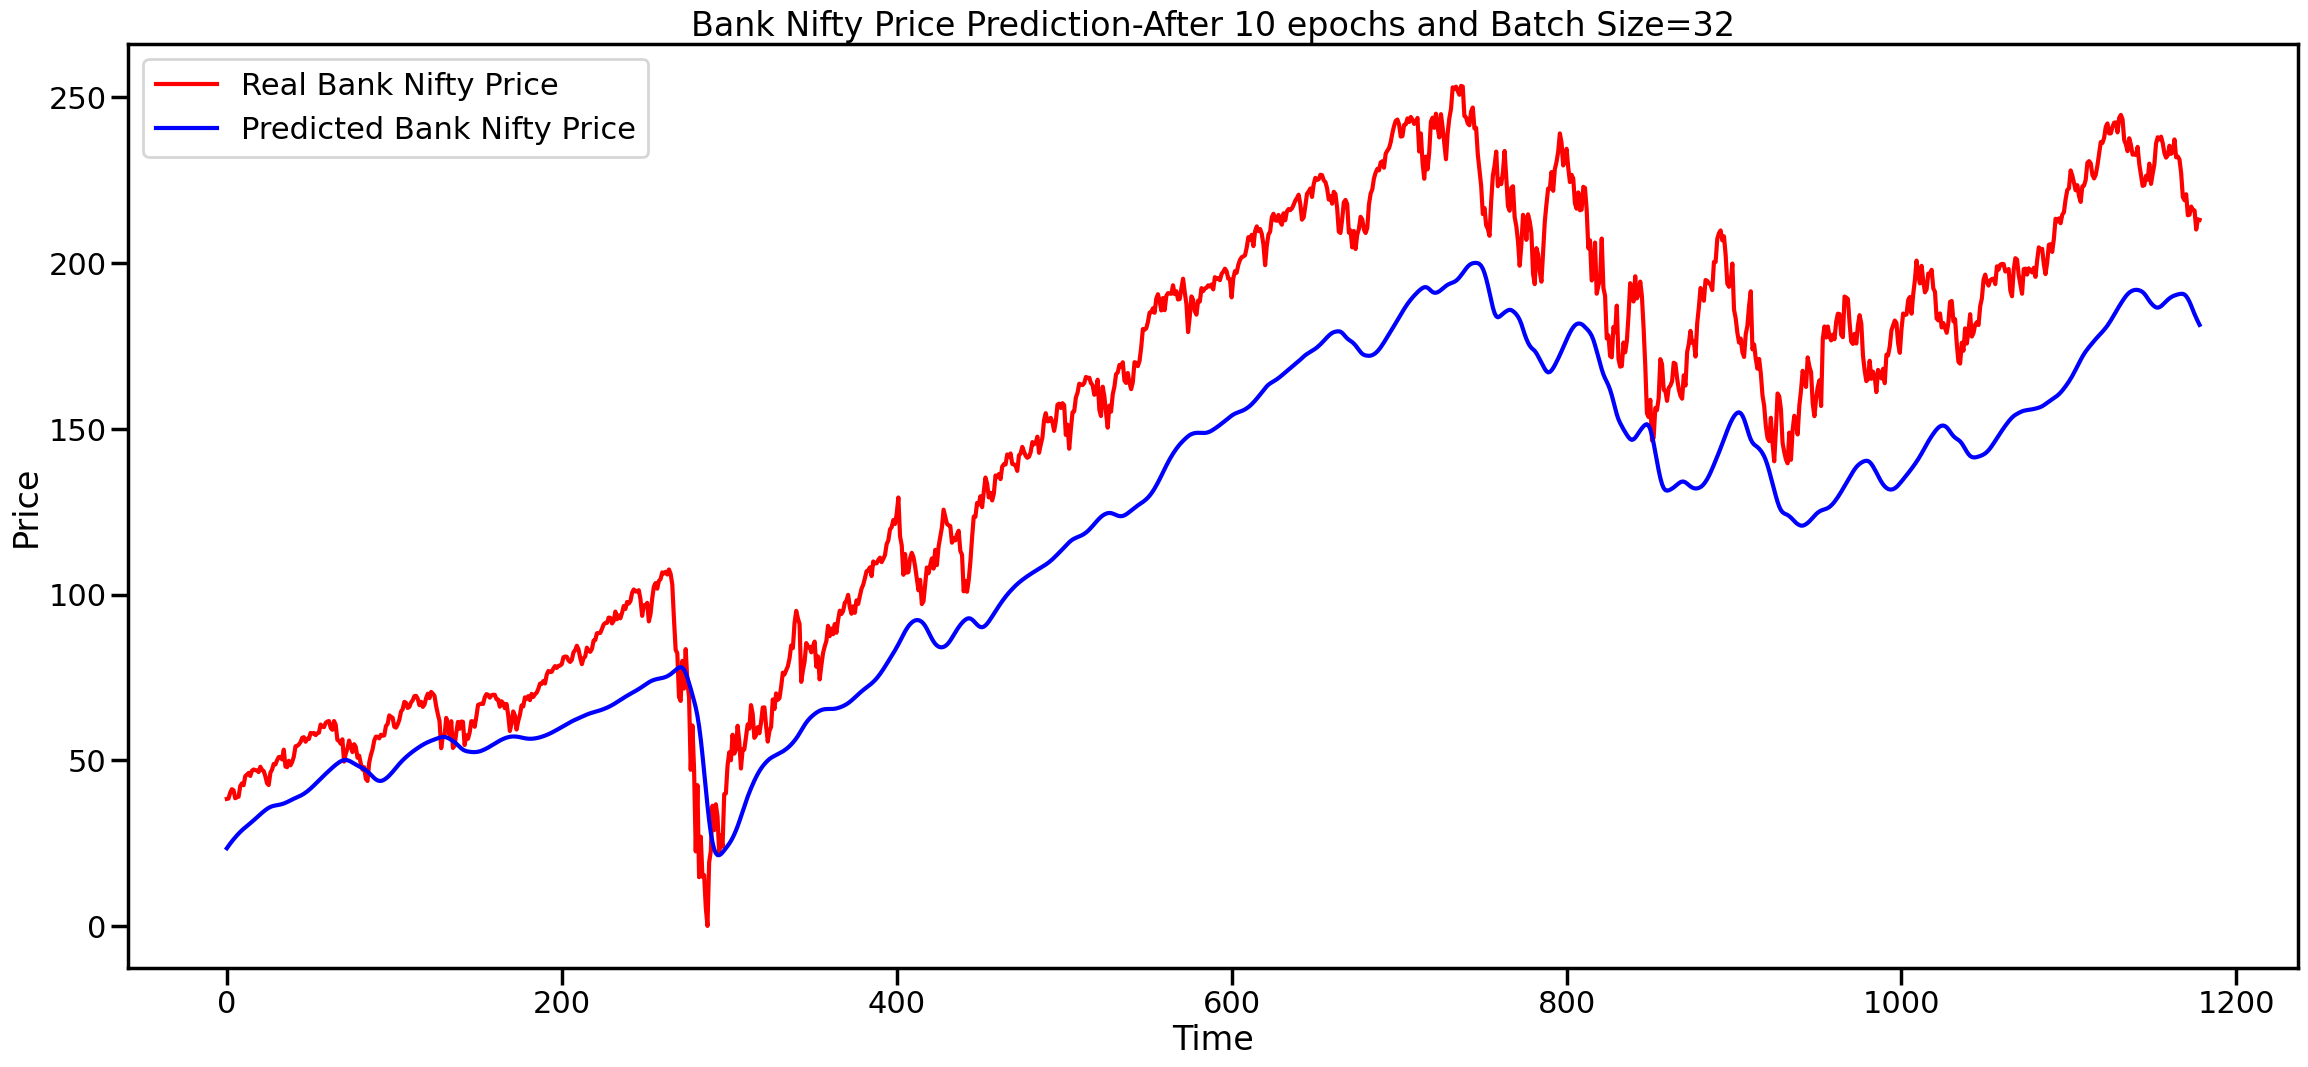

In [40]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Bank Nifty Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Bank Nifty Price')
plt.title('Bank Nifty Price Prediction-After 10 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

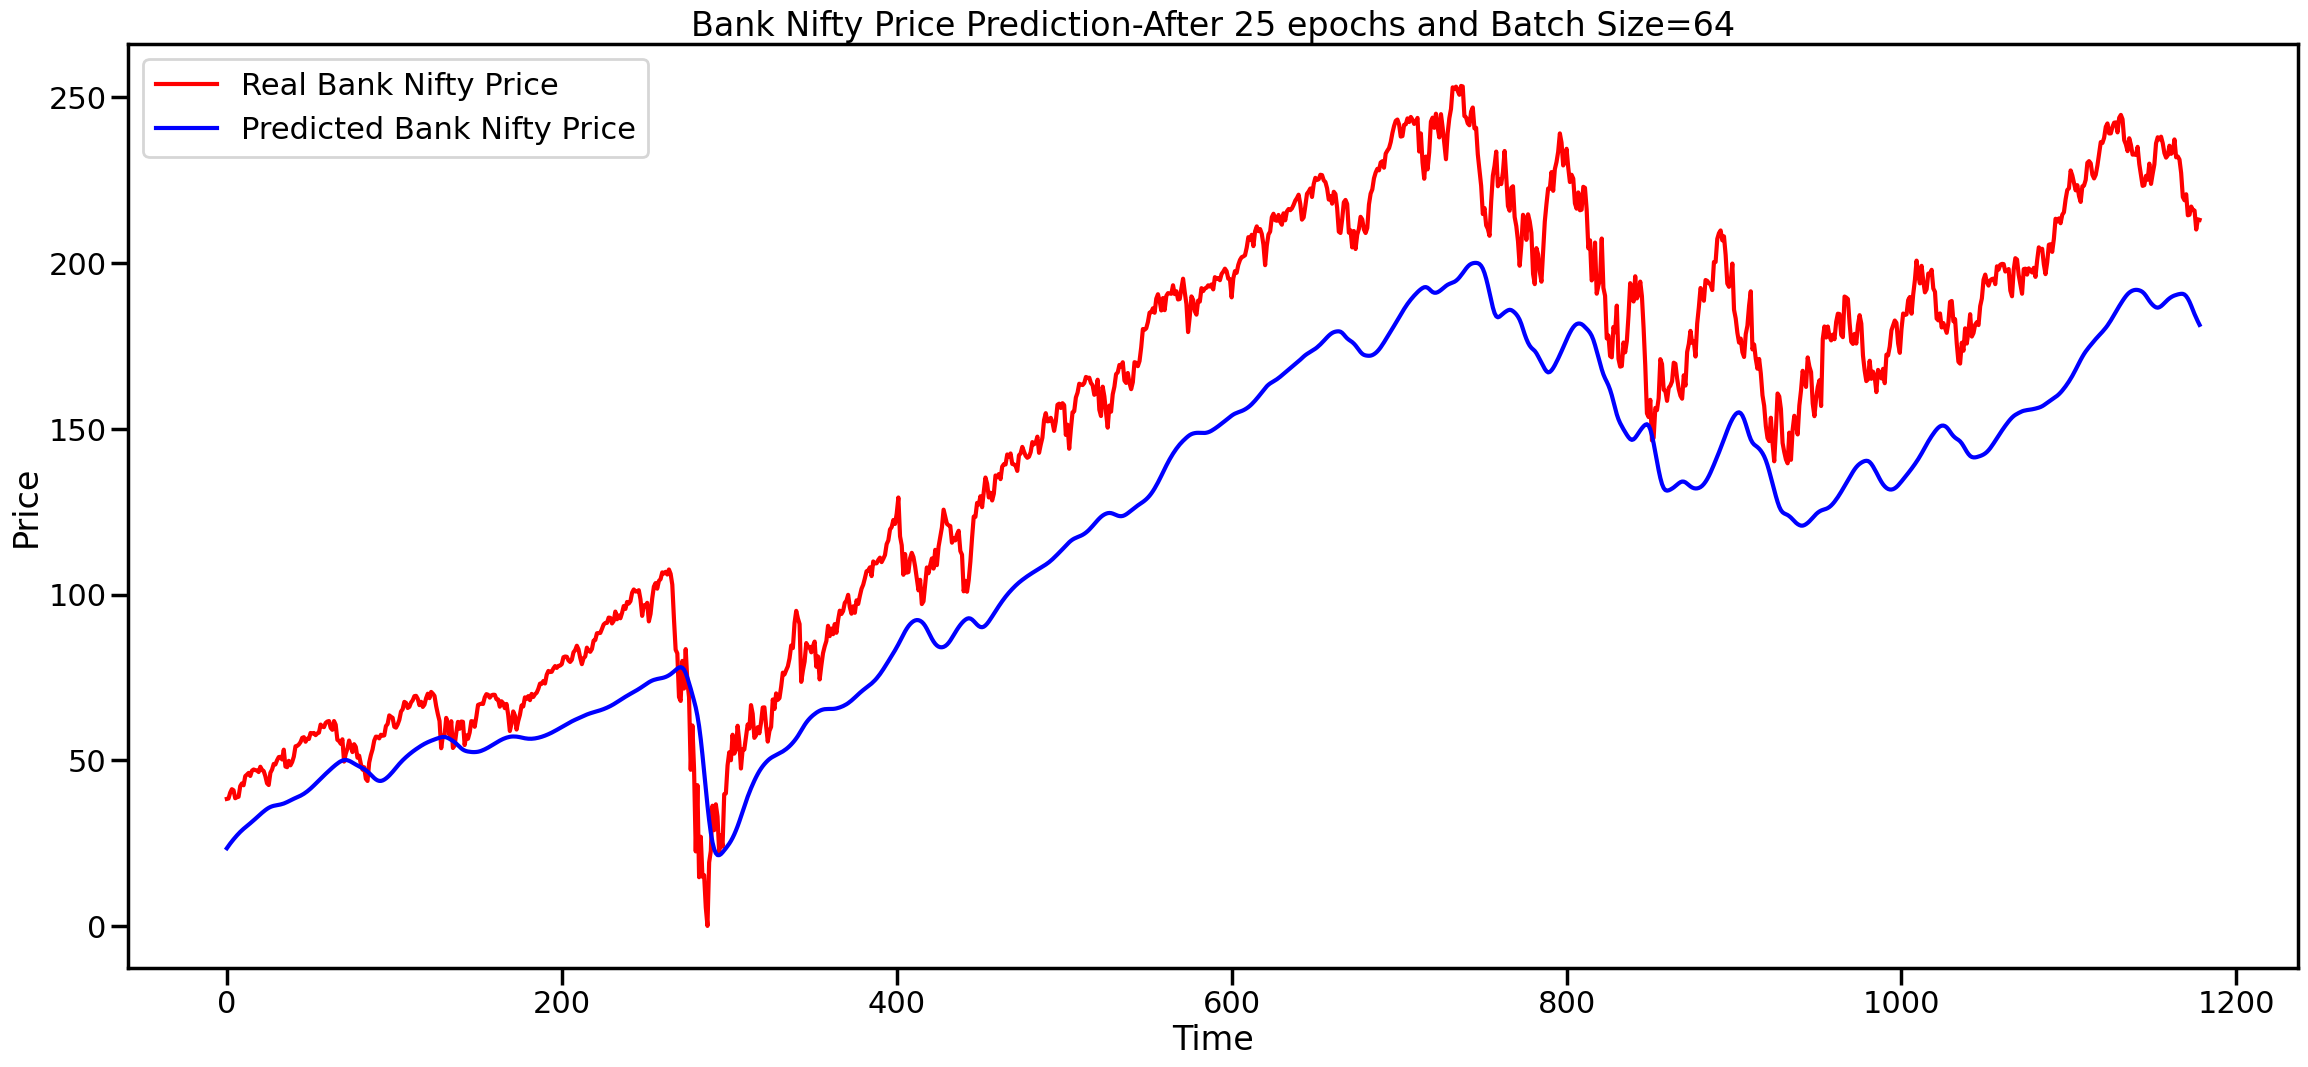

In [41]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Bank Nifty Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Bank Nifty Price')
plt.title('Bank Nifty Price Prediction-After 25 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

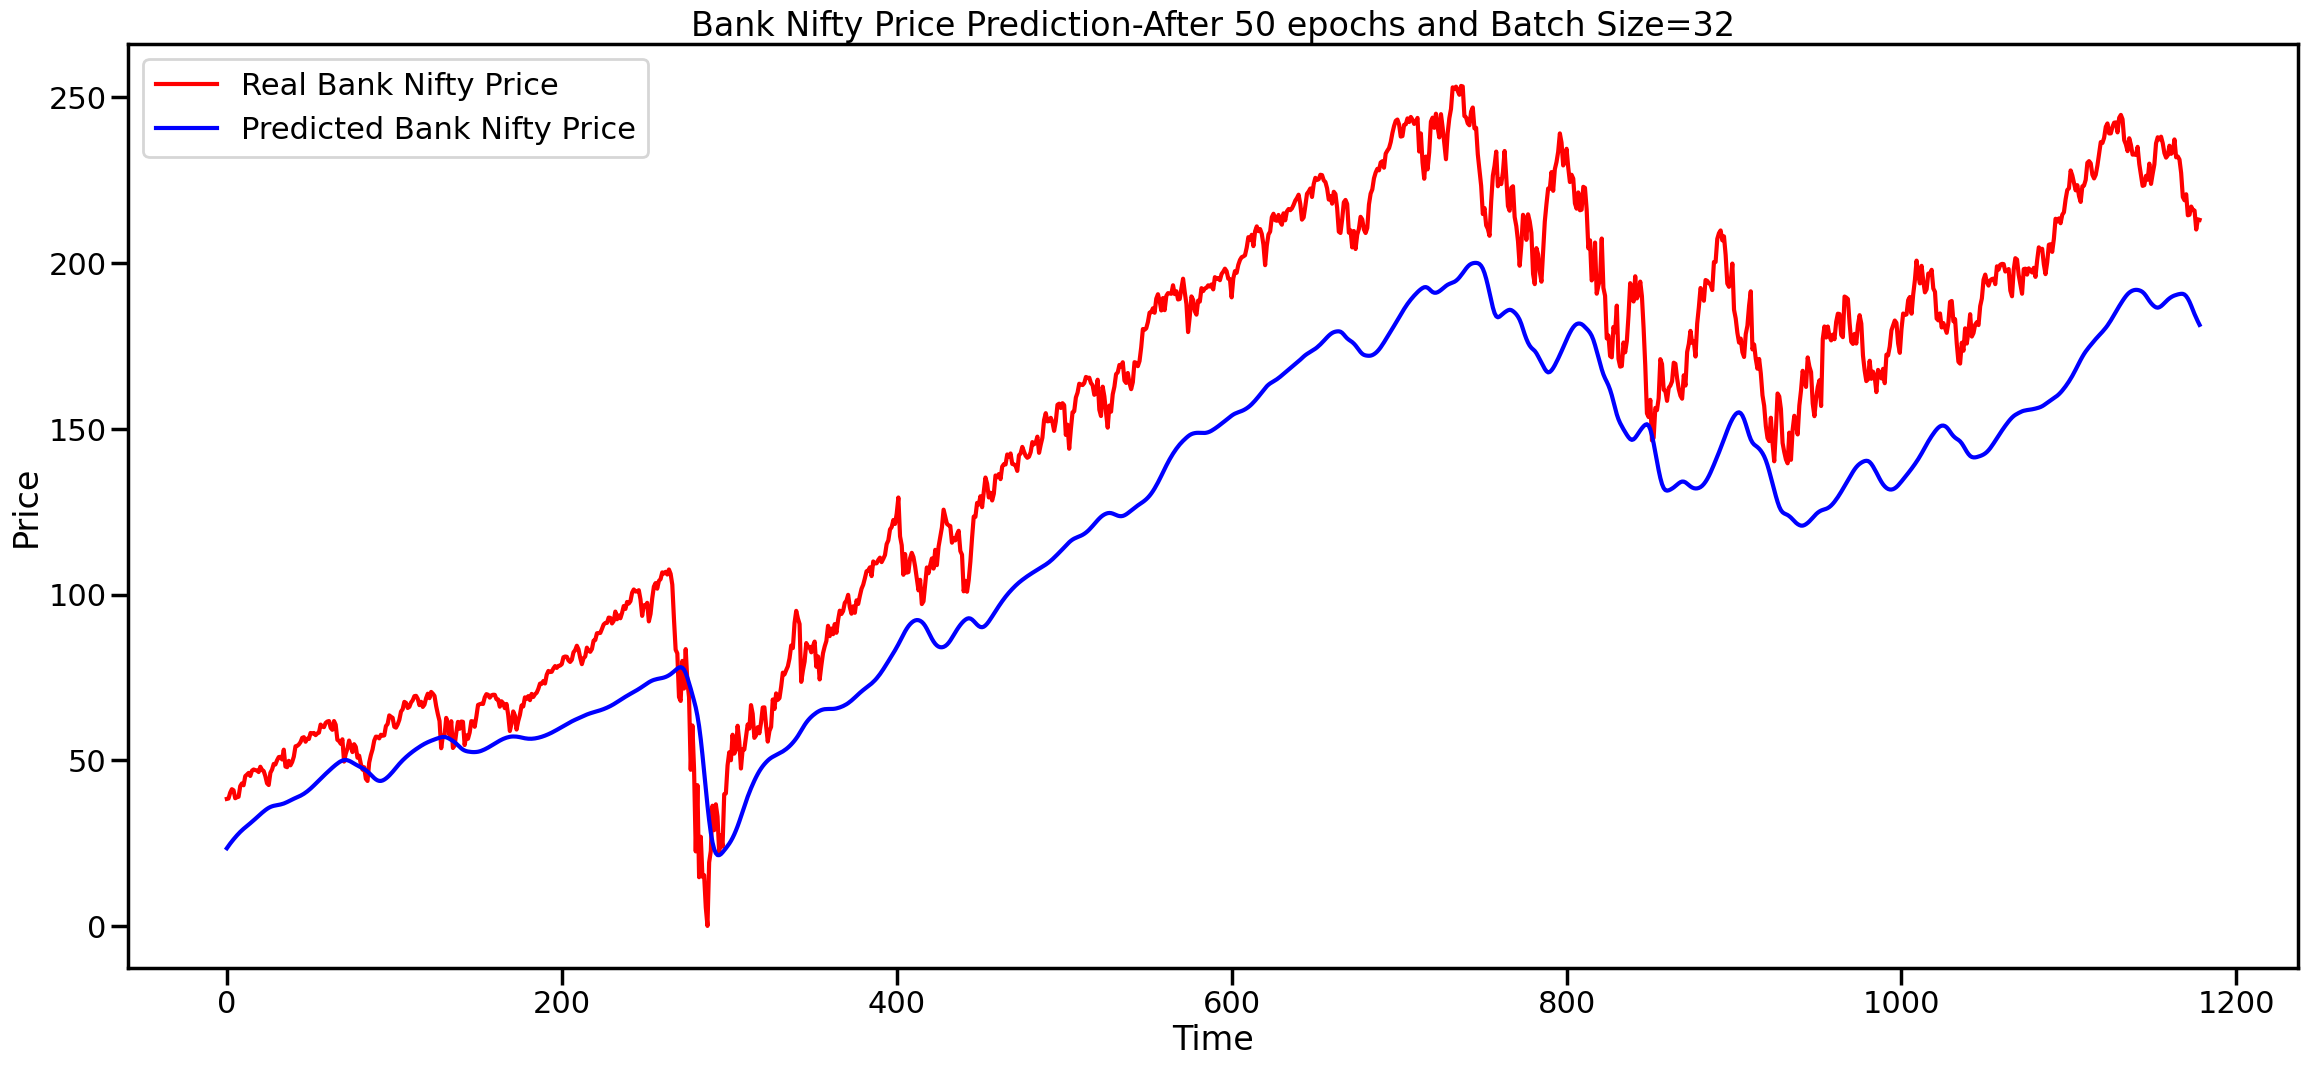

In [42]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Bank Nifty Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Bank Nifty Price')
plt.title('Bank Nifty Price Prediction-After 50 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()